In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from THESIS import LightCurveSampler, JAXNSmodelCreator, ModelComparison
from NSmodels import *

import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
from pioran import GaussianProcess, Inference
from pioran.psd import OneBendPowerLaw
from pioran.diagnostics import Visualisations
from scipy.stats import lognorm

INFO[2026-02-05 11:20:13,695]: Unable to initialize backend 'cuda': 
INFO[2026-02-05 11:20:13,695]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2026-02-05 11:20:13,696]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO[2026-02-05 11:20:15,112]: arviz_base not installed
INFO[2026-02-05 11:20:15,112]: arviz_stats not installed
INFO[2026-02-05 11:20:15,113]: arviz_plots not installed


In [2]:
simDATA = pd.read_csv('simDATAcsvs/simDATA_highALPHA_3_NumofWINDOW_4_20.csv')
simDATA.columns

Index(['ID', 'simSEED', 'sampleSEED', 'rms', 'noiseSIGMA', 'bendfreq',
       'lowalpha', 'highalpha', 'sharpness', 'NumofWINDOW', 'NightsperWINDOW',
       'OBSperiod', 'WINDOWwidth', 'dataLOSSfrac'],
      dtype='object')

In [3]:
k= 1001
row = simDATA[k:k+1]
row

,ID,simSEED,sampleSEED,rms,noiseSIGMA,bendfreq,lowalpha,highalpha,sharpness,NumofWINDOW,NightsperWINDOW,OBSperiod,WINDOWwidth,dataLOSSfrac
1001,2001.0,59982.0,23885.0,0.15,0.015,0.00274,-1.0,-3.0,10.0,14.0,20,6,60,0.2


In [4]:
def bend_pl(f, norm, f_bend, alph_lo, alph_hi, sharpness):
    '''
    Function for bend power_law creation
    '''
    powmod = (norm*(f/f_bend)**alph_lo)/(1.+(f/f_bend)**(sharpness*(alph_lo-alph_hi)))**(1./sharpness)
    return powmod

l = LightCurveSampler(N=2**21, rms=float(row.rms), simulatorSEED= int(row.simSEED), verbose=False)
l.load_powerspec(bend_pl, [200,  float(row.bendfreq), 
                            float(row.lowalpha),
                            float(row.highalpha),
                            float(row.sharpness)], 
                            plot=False)
l.LCsimulator()
simTIME, simLC, simLCerr , lc = l.sampler(NightsperWINDOW = int(row.NightsperWINDOW), 
                                            NumofWINDOW = int(row.NumofWINDOW),
                                            OBSperiod = float(row.OBSperiod),
                                            WINDOWwidth = float(row.WINDOWwidth),
                                            samplerSEED = int(row.sampleSEED),
                                            dataLOSSfrac = float(row.dataLOSSfrac), 
                                            noiseSIGMA = float(row.noiseSIGMA), plot=False)

np.min(np.diff(simTIME))

0.00011415525113989133

In [5]:
t, y, yerr = simTIME, simLC, simLCerr

In [6]:
psd = OneBendPowerLaw([1, 1, 1, 1])
gp = GaussianProcess(
    psd,
    t,
    y,
    yerr,
    S_low=100,
    S_high=20,
    use_tinygp=True,
    n_components=10,
    method="SHO")

In [7]:
np.min(np.diff(t))

0.00011415525113989133

In [8]:
min_index_1, max_index_1 = -0.25, 2
min_f_1, max_f_1 = 1/(t[-1]-t[0]),  4
min_index_2, max_index_2 = 0.5, 4
log10_min_c = -7  # log10min value for const

print("index1 range : ", min_index_1, " -", max_index_1)
print("f1 range : ", min_f_1, " -", max_f_1)
print("index2 range : ", min_index_2, " -", max_index_2)

def priors(cube):
    params = cube.copy()
    params[0] = cube[0] * (max_index_1 - min_index_1) + min_index_1  # alpha_1
    params[1] = 10 ** ( cube[1] * (np.log10(max_f_1)     - np.log10(min_f_1)) + np.log10(min_f_1) + log10_min_c)  # f_1
    params[2] = cube[2] * (max_index_2 - min_index_2) + min_index_2  # alpha_2
    params[3] = lognorm.ppf(cube[3], 1.25, loc=0, scale=0.5)  # var
    params[4] = cube[4] * 4.9 + 0.1  # nu
    params[5] = lognorm.ppf(cube[5], 1, loc=0, scale=3)  # mu
    return params

index1 range :  -0.25  - 2
f1 range :  0.15240083507306884  - 4
index2 range :  0.5  - 4


>>>>>> The config file already exists. Loading the previous config.
>>>>>> Check the config file:
>>>>>> The config file is the identical.

>>>>>> The PSD model is a SHO decomposition, checking the approximation.


DEBUG[2024-03-27 18:04:48,284]: ReactiveNestedSampler: dims=6+0, resume=True, log_dir=results, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


AssertionError: Error in loglikelihood function: returned non-finite number: [-inf -inf] for input u=[[0.28461549 0.38882096 0.23142379 0.98956077 0.2673062  0.80850193]
 [0.33819545 0.08108549 0.91995191 0.68353424 0.43952352 0.08423019]] p=[[3.90384852e-01 4.32323646e-08 1.30998328e+00 8.97615522e+00
  1.40980039e+00 7.17786076e+00]
 [5.10939759e-01 1.41023280e-08 3.71983167e+00 9.08335773e-01
  2.25366527e+00 7.56876286e-01]]

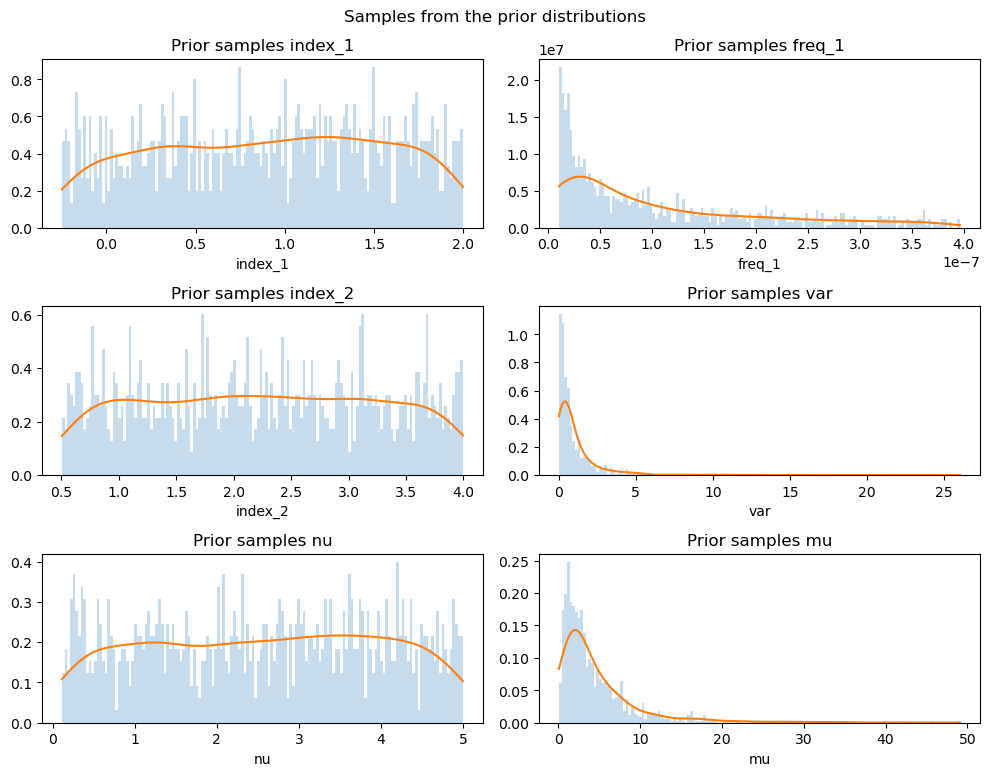

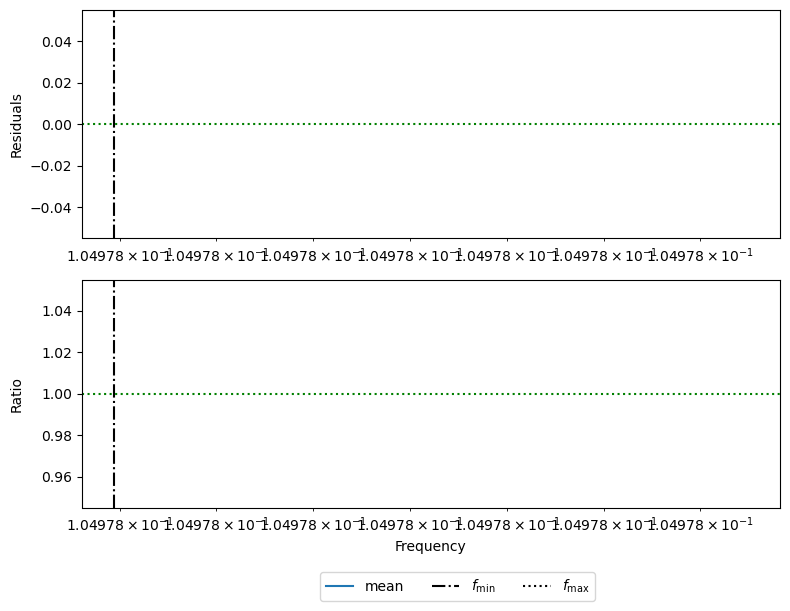

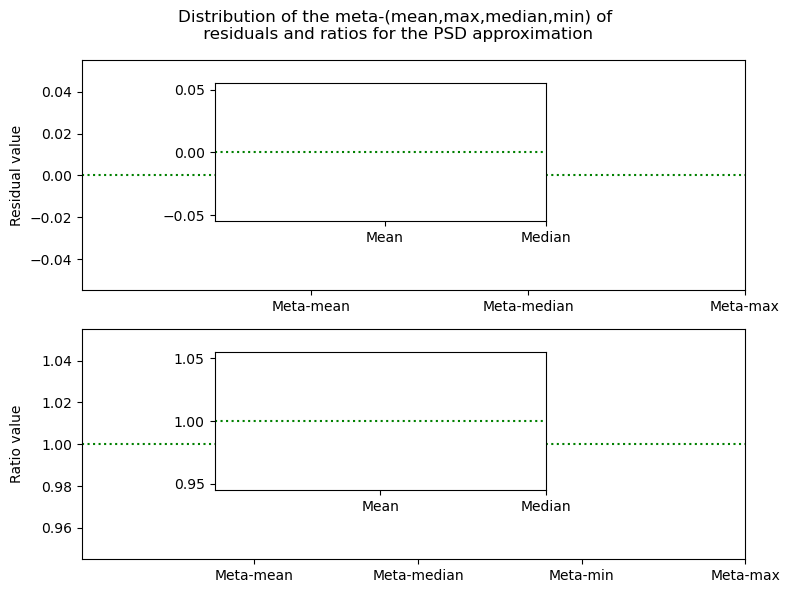

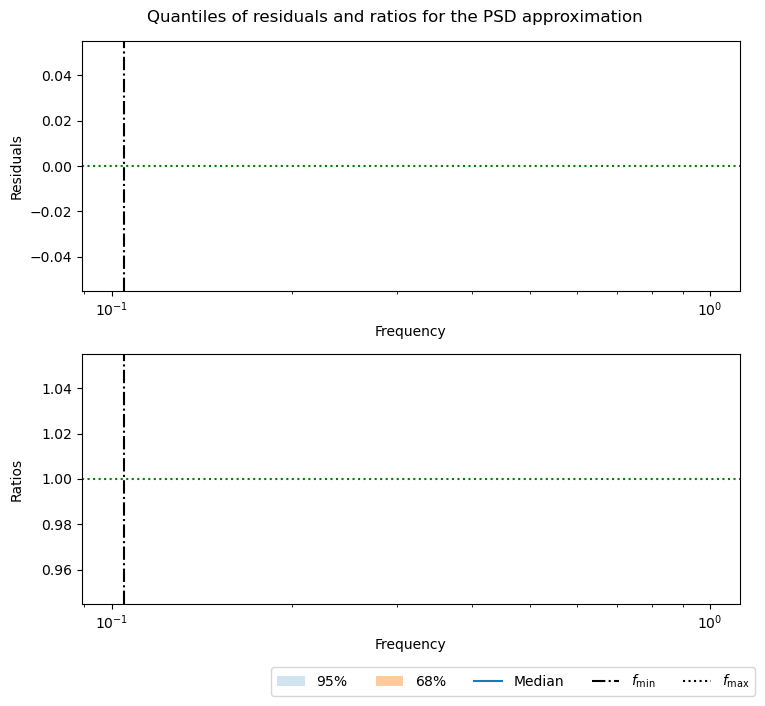

In [12]:
log_dir = "results"

inf = Inference(gp, priors, method="ultranest", run_checks=True, log_dir=log_dir)
res = inf.run(verbose=False)

<function __main__.priors(cube)>

In [20]:
samples = res["samples"]
vis = Visualisations(gp, filename=f"{inf.log_dir}/visualisations")
vis.plot_timeseries_diagnostics(samples)
vis.posterior_predictive_checks(samples,plot_PSD=True, plot_lombscargle=True,plot_ACVF=False)

Plotting timeseries diagnostics...
Sampling from the posterior residuals...


AttributeError: 'NoneType' object has no attribute 'GaussianProcess'